In [1]:
import pandas as pd
grocery_logs = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\grocery_logs.csv')
student_demographics = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\student_demographics.csv')
consumption_patterns = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\consumption_patterns.csv')
events = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\events.csv')
inventory_details = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\inventory_details.csv')
weather_data = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\weather_data.csv')


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
grocery_logs.isnull().sum(), events.isnull().sum(), student_demographics.isnull().sum(), consumption_patterns.isnull().sum(), weather_data.isnull().sum(), inventory_details.isnull().sum()

grocery_logs.fillna(grocery_logs.median(), inplace=True)
consumption_patterns.fillna(consumption_patterns.median(), inplace=True)
weather_data.fillna(weather_data.mode().iloc[0], inplace=True)


In [4]:
grocery_logs.drop_duplicates(inplace=True)
events.drop_duplicates(inplace=True)
student_demographics.drop_duplicates(inplace=True)
consumption_patterns.drop_duplicates(inplace=True)
weather_data.drop_duplicates(inplace=True)
inventory_details.drop_duplicates(inplace=True)


In [5]:
grocery_logs['date_purchased'] = pd.to_datetime(grocery_logs['date_purchased'])
consumption_patterns['date'] = pd.to_datetime(consumption_patterns['date'])
weather_data['date'] = pd.to_datetime(weather_data['date'])
inventory_details['last_updated'] = pd.to_datetime(inventory_details['last_updated'])


In [6]:
grocery_logs['day_of_week'] = grocery_logs['date_purchased'].dt.dayofweek
grocery_logs['month'] = grocery_logs['date_purchased'].dt.month
grocery_logs['year'] = grocery_logs['date_purchased'].dt.year


In [7]:
daily_consumption = consumption_patterns.groupby(['date', 'item_name'])['quantity_consumed'].sum().reset_index()


In [8]:
events['start_date'] = pd.to_datetime(events['start_date'])
events['end_date'] = pd.to_datetime(events['end_date'])


merged_data = pd.merge(grocery_logs, consumption_patterns, on='item_name', how='left')
merged_data = pd.merge(merged_data, weather_data, on='date', how='left')
merged_data = pd.merge(merged_data, student_demographics, left_on='id', right_on='student_id', how='left')
merged_data = pd.merge(merged_data, events, left_on='date', right_on='start_date', how='left')
merged_data = pd.merge(merged_data, inventory_details, on='item_name', how='left')

merged_data = pd.merge(merged_data, events, left_on='date', right_on='start_date', how='left')
merged_data['date'] = pd.to_datetime(merged_data['date'])


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
merged_data[['temperature', 'humidity', 'quantity_consumed']] = scaler.fit_transform(merged_data[['temperature', 'humidity', 'quantity_consumed']])


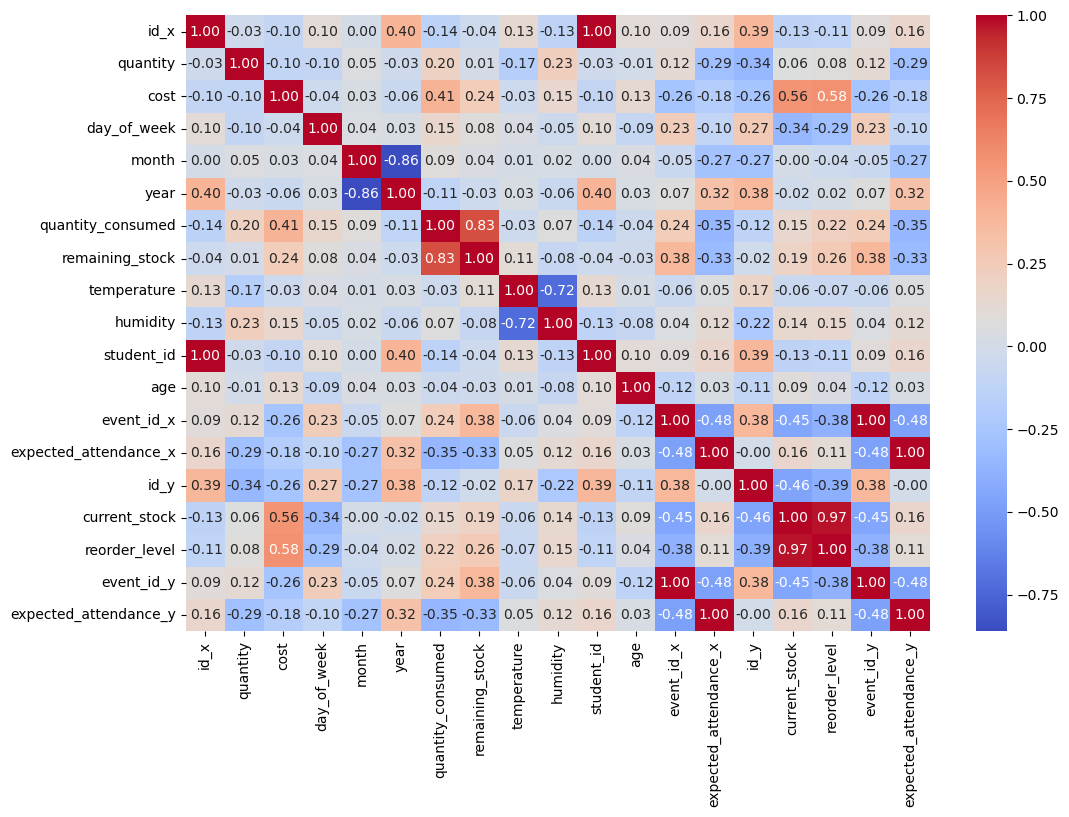

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = merged_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = merged_data[['temperature', 'humidity', 'quantity_consumed', 'day_of_week', 'month']]
y = merged_data['quantity']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (200, 5)
Test set shape: (51, 5)


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_imputed, y_train)

y_rf_pred = rf_model.predict(X_test_imputed)

rf_mae = mean_absolute_error(y_test, y_rf_pred)
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Model Performance:")
print("Mean Absolute Error (MAE):", rf_mae)
print("Mean Squared Error (MSE):", rf_mse)
print("R-squared Score:", rf_r2)


Random Forest Model Performance:
Mean Absolute Error (MAE): 28.02401960784314
Mean Squared Error (MSE): 2139.413721405229
R-squared Score: 0.6931797330575528


In [13]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_imputed, y_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best hyperparameters found: ", best_params)

y_pred_best_rf = best_rf_model.predict(X_test_imputed)

mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nRandom Forest Tuned Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_best_rf}")
print(f"Mean Squared Error (MSE): {mse_best_rf}")
print(f"R-squared Score: {r2_best_rf}")


Best hyperparameters found:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Random Forest Tuned Model Performance:
Mean Absolute Error (MAE): 26.939542483660134
Mean Squared Error (MSE): 2068.7014869281047
R-squared Score: 0.7033208041562824


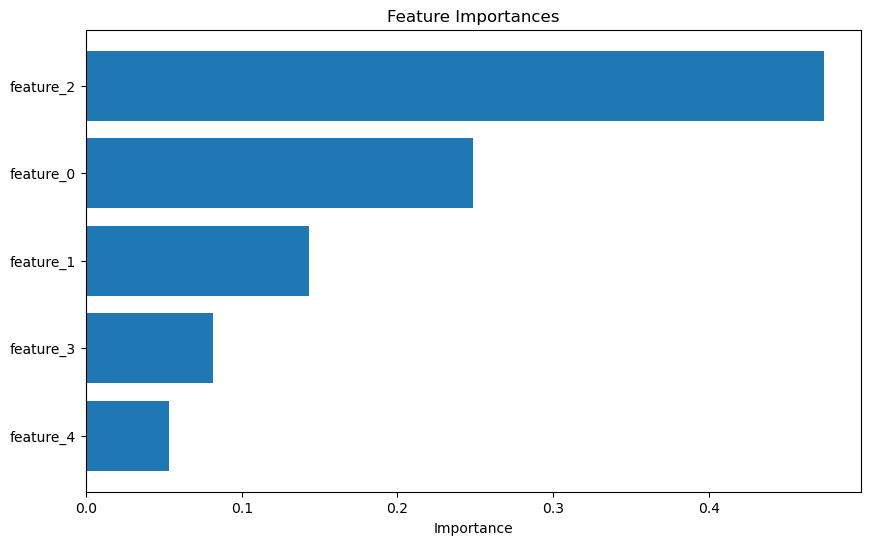

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])

imputer = SimpleImputer(strategy='mean')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

rf_model = RandomForestRegressor() 
rf_model.fit(X_train_imputed, y_train) 

importances = rf_model.feature_importances_

indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(X_train_imputed.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train_imputed.shape[1]), X_train_imputed.columns[indices]) 
plt.xlabel("Importance")
plt.show()


In [15]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_test_imputed = imputer.fit_transform(X_test)

y_pred = rf_model.predict(X_test_imputed)


In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared Score: {r2}")


Test Set Performance:
Mean Absolute Error (MAE): 26.651633986928104
Mean Squared Error (MSE): 1828.434618736383
R-squared Score: 0.7377782556994039


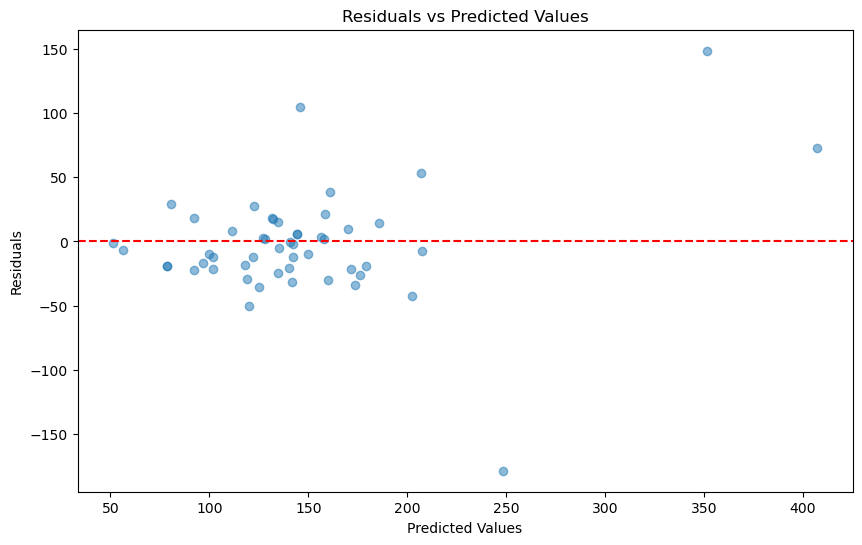

In [17]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


In [18]:
import pandas as pd
grocery_logs = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\grocery_logs.csv')
student_demographics = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\student_demographics.csv')
consumption_patterns = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\consumption_patterns.csv')
events = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\events.csv')
inventory_details = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\inventory_details.csv')
weather_data = pd.read_csv(r'C:\Users\Sweety Chittineni\Downloads\grocery recommendation system\dataset\weather_data.csv')


In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

grocery_logs = pd.DataFrame({
    'id': [1, 2, 3],
    'item_name': ['Rice', 'Rice', 'Potatoes'],
    'quantity': [10, 5, 3],
    'date_purchased': ['2024-10-01', '2024-10-02', '2024-10-01'],
    'cost': [20, 10, 6],
    'supplier': ['Supplier A', 'Supplier B', 'Supplier A']
})

events = pd.DataFrame({
    'event_id': [1, 2],
    'event_name': ['Event A', 'Event B'],
    'start_date': ['2024-10-01', '2024-10-02'],
    'end_date': ['2024-10-01', '2024-10-02'],
    'expected_attendance': [100, 150]
})

student_demographics = pd.DataFrame({
    'student_id': [1, 2],
    'home_state': ['California', 'Texas'],
    'dietary_preference': ['Vegan', 'Non-Vegan'],
    'age': [20, 21],
    'gender': ['M', 'F'],
    'allergies': ['None', 'Peanuts']
})

consumption_patterns = pd.DataFrame({
    'date': ['2024-10-01', '2024-10-02', '2024-10-01', '2024-10-02'],
    'item_name': ['Rice', 'Rice', 'Potatoes', 'Potatoes'],
    'quantity_consumed': [5, 3, 2, 4]
})

weather_data = pd.DataFrame({
    'date': ['2024-10-01', '2024-10-02'],
    'weather_condition': ['Sunny', 'Rainy'],
    'temperature': [30, 22],
    'humidity': [50, 80]
})

inventory_details = pd.DataFrame({
    'item_name': ['Rice', 'Potatoes'],
    'current_stock': [5, 10],
    'reorder_level': [10, 15]
})

grocery_logs['date_purchased'] = pd.to_datetime(grocery_logs['date_purchased'])
events['start_date'] = pd.to_datetime(events['start_date'])
events['end_date'] = pd.to_datetime(events['end_date'])
consumption_patterns['date'] = pd.to_datetime(consumption_patterns['date'])
weather_data['date'] = pd.to_datetime(weather_data['date'])

consumption_patterns['month'] = consumption_patterns['date'].dt.month
consumption_patterns['day_of_week'] = consumption_patterns['date'].dt.dayofweek

merged_data = pd.merge(consumption_patterns, events, how='left', left_on='date', right_on='start_date')
merged_data = pd.merge(merged_data, weather_data, how='left', on='date')

merged_data.fillna({
    'quantity_consumed': 0,
    'expected_attendance': 0,
    'weather_condition': 'Unknown',
    'temperature': 0,
    'humidity': 0
}, inplace=True)

monthly_consumption = merged_data.groupby(['month', 'item_name'])['quantity_consumed'].mean().reset_index()

X = merged_data[['month', 'day_of_week', 'expected_attendance', 'temperature', 'humidity']]
y = merged_data['quantity_consumed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

future_date = pd.to_datetime('2024-10-03')
future_month = future_date.month
future_day_of_week = future_date.dayofweek

future_weather = {'temperature': 25, 'humidity': 60}
future_event = {'expected_attendance': 0}

X_future = pd.DataFrame({
    'month': [future_month],
    'day_of_week': [future_day_of_week],
    'expected_attendance': [future_event['expected_attendance']],
    'temperature': [future_weather['temperature']],
    'humidity': [future_weather['humidity']]
})

predicted_quantity = model.predict(X_future)[0]

predicted_quantities = pd.DataFrame({
    'item_name': ['Rice', 'Potatoes'],
    'predicted_quantity': [predicted_quantity, predicted_quantity]  
})

predicted_quantities = pd.merge(predicted_quantities, inventory_details, on='item_name', how='left')

predicted_quantities['adjusted_quantity'] = predicted_quantities['predicted_quantity'] - predicted_quantities['current_stock']

predicted_quantities['adjusted_quantity'] = predicted_quantities['adjusted_quantity'].apply(lambda x: max(0, x))

print(predicted_quantities[['item_name', 'predicted_quantity', 'adjusted_quantity']])


  item_name  predicted_quantity  adjusted_quantity
0      Rice             2.82785                  0
1  Potatoes             2.82785                  0


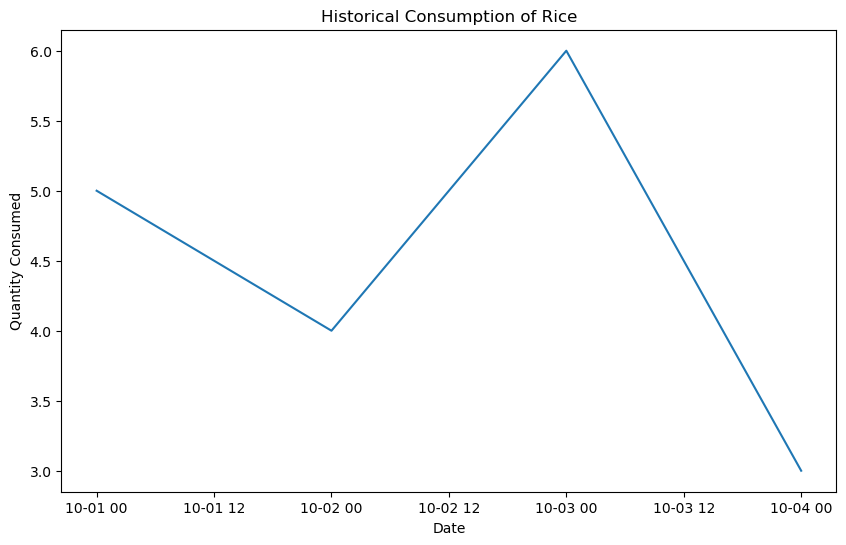

Forecasted quantity of Rice for 2024-10-05: 6.969081873860152
Adjusted quantity to order: 1.9690818738601523


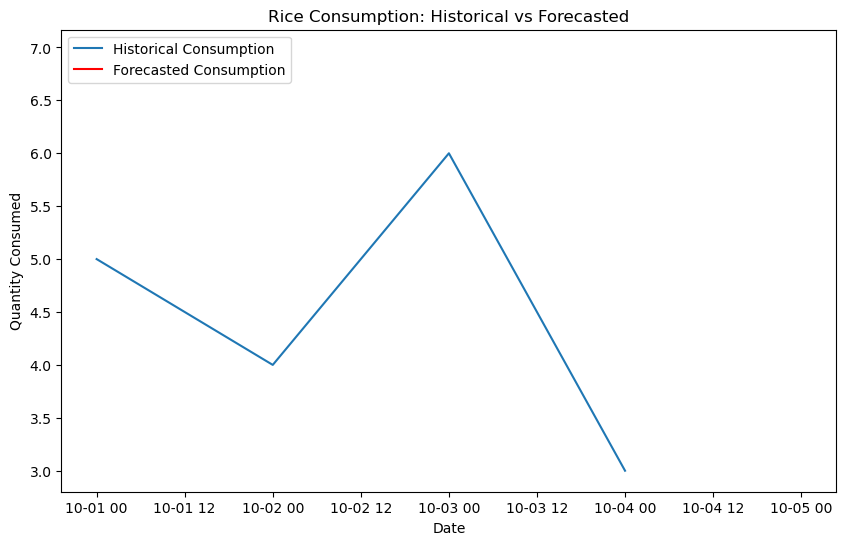

            predicted_quantity
2024-10-05            6.969082


In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime

consumption_patterns = pd.DataFrame({
    'date': ['2024-10-01', '2024-10-02', '2024-10-03', '2024-10-04'],
    'item_name': ['Rice', 'Rice', 'Rice', 'Rice'],
    'quantity_consumed': [5, 4, 6, 3]
})

consumption_patterns['date'] = pd.to_datetime(consumption_patterns['date'])

consumption_patterns.set_index('date', inplace=True)

rice_data = consumption_patterns[consumption_patterns['item_name'] == 'Rice']
rice_data = rice_data.resample('D').sum()  

plt.figure(figsize=(10, 6))
plt.plot(rice_data.index, rice_data['quantity_consumed'])
plt.title('Historical Consumption of Rice')
plt.xlabel('Date')
plt.ylabel('Quantity Consumed')
plt.show()


model = sm.tsa.ARIMA(rice_data['quantity_consumed'], order=(5, 1, 0)) 
model_fit = model.fit()

future_date = '2024-10-05'  
forecast_steps = (pd.to_datetime(future_date) - rice_data.index[-1]).days  

forecast = model_fit.forecast(steps=forecast_steps)
print(f"Forecasted quantity of Rice for {future_date}: {forecast[0]}")

current_inventory = 5  

adjusted_quantity = max(0, forecast[0] - current_inventory)  
print(f"Adjusted quantity to order: {adjusted_quantity}")

forecast_index = pd.date_range(start=rice_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['predicted_quantity'])

plt.figure(figsize=(10, 6))
plt.plot(rice_data.index, rice_data['quantity_consumed'], label='Historical Consumption')
plt.plot(forecast_df.index, forecast_df['predicted_quantity'], label='Forecasted Consumption', color='red')
plt.title('Rice Consumption: Historical vs Forecasted')
plt.xlabel('Date')
plt.ylabel('Quantity Consumed')
plt.legend()
plt.show()

print(forecast_df)
